# This is the code for the best classification model we've trained:
*   LSTM mdoel with one hidden layer
*   Two inputs: price, sentiment 
*   We use TensorBoard to track and visualize the performance metrics such as loss and accuracy. We've commented out the codes for connecting with TensorBoard because they only work in **Google Colab** environment. If you are using **Jupyter**, here is the link for setting up TensorBoard: https://www.tensorflow.org/tensorboard/r2/tensorboard_in_notebooks



In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.utils import to_categorical
import keras
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
import numpy as np

Using TensorFlow backend.


In [2]:
import pandas as pd
data =  pd.read_csv('../Files/price_emotion_labeled.csv')
data['Date']=pd.to_datetime(data['Date'])
data = data.sort_values(['Date'], ascending=[True])

price = data[['Date','Close']].copy()
sentiment = data[['Average_Anger','Average_Joy','Average_Sadness','Average_Fear','Average_Disgust']].copy()
price = price[['Close']].copy()

# Reshape the data and split data into train set and test set

In [3]:
datalength = data.shape[0]

# Scaled the input into normalize vector
scaler_value = MinMaxScaler(feature_range=(0, 1))

values = data['Close'].values.reshape(datalength,1)
values = values.astype('float32')
values = scaler_value.fit_transform(values)
values = values.reshape(datalength,1,1)

scaler_sentiment = MinMaxScaler(feature_range=(0,1))
sentiments = sentiment.values
sentiments = scaler_sentiment.fit_transform(sentiments)
sentiments = sentiments.reshape(datalength,1,5) # Five sentiment features

In [4]:
# Split train data and test data
train_size = int(len(values) * 0.7)
test_size = len(values) - train_size
trainP, testP = values[0:train_size,:,:], values[train_size:len(values),:,:]

trainS,testS = sentiments[0:train_size,:,:], sentiments[train_size:len(values),:,:]
print(len(trainP), len(testP))
print(len(trainS), len(testS))
split = train_size

20388 8738
20388 8738


# Prepare the input vector with n time look back 

In [5]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back : i, 0]
        dataX.append(a)
        dataY.append(dataset[i , 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

## Lag = 51
Assume the past 51 hours (t-51) price will affect the price in time t

In [6]:
look_back_51 = 51

trainX,trainY = create_dataset(trainP,look_back_51)
testX,testY = create_dataset(testP,look_back_51)

trainS,trains = create_dataset(trainS,look_back_51)
testS,tests = create_dataset(testS,look_back_51)

20337
8687
20337
8687


In [7]:
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1, testX.shape[1]))

trainY = np.reshape(trainY,(trainY.shape[0],1))

# 1 Layer, Epoch=50, Price+Sentiment

In [8]:
import keras
# Train the model with lag=51
def buildModel_lag51(dataLength, labelLength):
    price=Input(shape=(dataLength, 51),name='price') 
    sentiment = Input(shape=(51, 5),name='sentiment')
    
    priceLayers = LSTM(64, return_sequences=False)(price)
    sentimentLayers = LSTM(64, return_sequences=False)(sentiment)
    
    output = keras.layers.concatenate(
        [priceLayers,sentimentLayers,]
    )
    output = Dense(labelLength, activation='sigmoid',name='output')(output)
    
    model = Model(
        inputs = [price,sentiment],
        outputs=[output]
    )
    model.compile(optimizer='adam',loss='mse')
    return model

import math
def predict_and_score_mixed(model, X1, X2, Y):
    # Make predictions on the original scale of the data.
    pred = model.predict([X1, X2])
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = [Y]
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

In [9]:
print(trainX.shape)
print(trainS.shape)
print(trainY.shape)

(20337, 1, 51)
(20337, 51, 5)
(20337, 1)


In [10]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model

lstm_lag51 = buildModel_lag51(1,1)

lstm_lag51.fit([trainX,trainS],[trainY],
              epochs = 50, 
              verbose = 1,
              validation_split=0.1,
              shuffle=True)

W0909 15:33:34.262253 14472 deprecation_wrapper.py:119] From C:\Users\Ray\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0909 15:33:34.281242 14472 deprecation_wrapper.py:119] From C:\Users\Ray\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0909 15:33:34.282199 14472 deprecation_wrapper.py:119] From C:\Users\Ray\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0909 15:33:34.592107 14472 deprecation_wrapper.py:119] From C:\Users\Ray\Anaconda3\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0909 15:33:34.765850 14472 deprecation.py:323] From C:\Users\Ray\Anaconda3\lib\site-pac

Train on 18303 samples, validate on 2034 samples
Epoch 1/50
18303/18303 [==============================] - 15s 792us/step - loss: 0.0064 - val_loss: 0.0045
Epoch 2/50
18303/18303 [==============================] - 16s 883us/step - loss: 3.2601e-04 - val_loss: 0.0018
Epoch 3/50
18303/18303 [==============================] - 17s 929us/step - loss: 1.8120e-04 - val_loss: 9.1000e-04
Epoch 4/50
18303/18303 [==============================] - 17s 920us/step - loss: 1.3369e-04 - val_loss: 4.1252e-04
Epoch 5/50
18303/18303 [==============================] - 17s 921us/step - loss: 1.0546e-04 - val_loss: 3.1159e-04
Epoch 6/50
18303/18303 [==============================] - 17s 946us/step - loss: 9.2150e-05 - val_loss: 2.5556e-04
Epoch 7/50
18303/18303 [==============================] - 17s 947us/step - loss: 7.6180e-05 - val_loss: 2.6594e-04
Epoch 8/50
18303/18303 [==============================] - 18s 964us/step - loss: 7.2535e-05 - val_loss: 6.1204e-04
Epoch 9/50
18303/18303 [===================

In [11]:
import math
rmse_train, train_predict = predict_and_score_mixed(lstm_lag51, trainX, trainS, trainY)
rmse_test, test_predict = predict_and_score_mixed(lstm_lag51, testX, testS, testY)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 0.01 RMSE
Test data score: 0.01 RMSE


In [12]:
inverse_test_predict = scaler_value.inverse_transform(test_predict.reshape(-1, 1))
inverse_test_actual = scaler_value.inverse_transform(testY.reshape(-1, 1))
print(math.sqrt(mean_squared_error(inverse_test_actual, inverse_test_predict)))

172.38457981900527


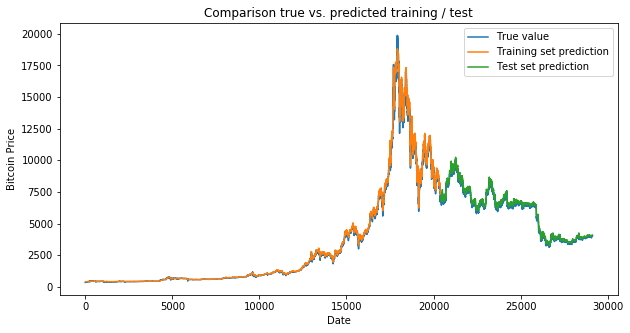

In [13]:
import matplotlib.pyplot as plt
# Start with training predictions.
train_predict_plot = np.empty_like(price)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back_51:len(train_predict) + look_back_51, :] = scaler_value.inverse_transform(train_predict.reshape(-1, 1))
#inverse the normalization value back 

# Add test predictions.
test_predict_plot = np.empty_like(price)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + look_back_51*2:len(price), :] = scaler_value.inverse_transform(test_predict.reshape(-1, 1))

# Create the plot.
price = data[['Date','Close']].copy()
price = price[['Close']].copy()
price = price.values

plt.figure(figsize = (10, 5))
plt.plot(price, label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Date")
plt.ylabel("Bitcoin Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
# plt.xlim(26000,26100)
# plt.ylim(2000,7500)
plt.show()

In [14]:
total_length = price.shape[0]
arr = np.empty((0,1), float)
arr_percent = np.empty((0,1), float)

for i in range(trainX.shape[0]+look_back_51*2,total_length):
    arr = np.append(arr,price[i]-test_predict_plot[i].flatten())
    arr_percent = np.append(arr_percent,((price[i]-test_predict_plot[i])).flatten())

evl_lag51 = pd.DataFrame({'Difference': arr.flatten(),
                  'Percentage':arr_percent.flatten()})
print(abs(evl_lag51["Difference"]).mean()) 
# Show the average absolute difference between actual price and predict price

159.49910345125804
